In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import time
from tensorflow.python.layers.base import Layer

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/")
num_train=mnist.train.num_examples
num_val=mnist.validation.num_examples
num_test=mnist.test.num_examples

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [3]:
transform_mean=np.ones(784)*0.5
transform_std=np.ones(784)*0.5

In [4]:
width=28
height=28
channel=1

In [5]:
tf.reset_default_graph()
X=tf.placeholder(dtype=tf.float32,shape=[None,height*width*channel],name='input_image')
y=tf.placeholder(dtype=tf.int32,shape=[None])

mask_psed_neg=tf.reshape(tf.cast(tf.equal(y,1),tf.float32),(-1,1))
mask_not_psed_neg=tf.reshape(tf.cast(tf.logical_not(tf.equal(y,1)),tf.float32),(-1,1))

y_onehot=tf.one_hot(y,3)

class CNN_bn_Classifier(Layer):
    def __init__(self):
        self.conv1=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv1',_reuse=tf.AUTO_REUSE)
        self.conv2=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv2',_reuse=tf.AUTO_REUSE)
        self.conv3=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv3',_reuse=tf.AUTO_REUSE)
        self.batch_norm1=tf.layers.BatchNormalization(axis=3,name='bn1',_reuse=tf.AUTO_REUSE)
        self.batch_norm2=tf.layers.BatchNormalization(axis=3,name='bn2',_reuse=tf.AUTO_REUSE)
        self.batch_norm3=tf.layers.BatchNormalization(axis=3,name='bn3',_reuse=tf.AUTO_REUSE)
        self.max_pool=tf.layers.MaxPooling2D(pool_size=2,strides=2,_reuse=tf.AUTO_REUSE)
        self.fc=tf.layers.Dense(units=3,_reuse=tf.AUTO_REUSE)
    
    def __call__(self,inputs,is_training):
        out1=self.max_pool(self.batch_norm1(self.conv1(inputs),training=is_training))
        out2=self.max_pool(self.batch_norm2(self.conv2(out1),training=is_training))
        out3=self.max_pool(self.batch_norm3(self.conv3(out2),training=is_training))
        score=self.fc(tf.layers.flatten(out3))
        return score
    
class CNN_Classifier(Layer):
    def __init__(self):
        self.conv1=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv1',_reuse=tf.AUTO_REUSE)
        self.conv2=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv2',_reuse=tf.AUTO_REUSE)
        self.conv3=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv3',_reuse=tf.AUTO_REUSE)
        self.max_pool=tf.layers.MaxPooling2D(pool_size=2,strides=2,_reuse=tf.AUTO_REUSE)
        self.avg_pool=tf.layers.AveragePooling2D(pool_size=7,strides=7,_reuse=tf.AUTO_REUSE)
        self.fc=tf.layers.Dense(units=3,_reuse=tf.AUTO_REUSE)
    
    def __call__(self,inputs):
        out1=self.max_pool(self.conv1(inputs))
        out2=self.max_pool(self.conv2(out1))
        out3=self.avg_pool(self.conv3(out2))
        score=self.fc(tf.layers.flatten(out3))
        return score
    
class NN_Classifier(Layer):
    def __init__(self):
        self.linear1=tf.layers.Dense(units=512,name='linear1',activation=tf.nn.relu,_reuse=tf.AUTO_REUSE)
        self.linear2=tf.layers.Dense(units=256,name='linear2',activation=tf.nn.relu,_reuse=tf.AUTO_REUSE)
        self.linear3=tf.layers.Dense(units=256,name='linear3',activation=tf.nn.relu,_reuse=tf.AUTO_REUSE)
        self.linear4=tf.layers.Dense(units=3,name='linear4',_reuse=tf.AUTO_REUSE)
    
    def __call__(self,inputs):
#         score=self.linear4(self.linear3(self.linear2(self.linear1(inputs))))
        score=self.linear4(self.linear1(inputs))
        return score    

    
class VAE(Layer):
    def __init__(self):
        self.lstm_hidden_dim=256
        self.latent_dim=128
        self.n_time=15
#         self.encoder_lstm=tf.contrib.rnn.LSTMCell(self.lstm_hidden_dim)
#         self.decoder_lstm=tf.contrib.rnn.LSTMCell(self.lstm_hidden_dim)
        self.encoder_lstm=tf.contrib.rnn.GRUCell(self.lstm_hidden_dim)
        self.decoder_lstm=tf.contrib.rnn.GRUCell(self.lstm_hidden_dim)
        self.encode_mean=tf.layers.Dense(units=self.latent_dim,name='encode_mean')   # calculate mean of z
        self.encode_std=tf.layers.Dense(units=self.latent_dim,name='encode_std')   # calculate std of z
        self.unit_gaussian=tf.distributions.Normal(loc=tf.zeros(self.latent_dim),scale=5.0*tf.ones(self.latent_dim))
        self.emit_net=tf.layers.Dense(units=height*width*channel,name='emit_net')
        
        
    def __call__(self,inputs):
        batch_size=tf.shape(inputs)[0]
        state_encode=self.encoder_lstm.zero_state(batch_size, tf.float32)   # lstm tuple (c,h)
        state_decode=self.decoder_lstm.zero_state(batch_size, tf.float32)   # lstm tuple (c,h)
        original_image=tf.layers.flatten(inputs)
        output_image=None
        latent_loss_his=[]
        classifier_loss_his=[]
        likelihood_his=[]
        predict_his=[]
        image_his=[]
        
        for t in range(self.n_time):
            if t==0:
                image=original_image
            else:
                # use output_image for fake images, use original image for real image
                image=mask_psed_neg*output_image+mask_not_psed_neg*original_image
            image_his.append(image)
            '''
            Part I: Classifier
            '''
            classifier_scope="CNN_classifier_"+str(t)
#             input_image=tf.reshape(image,(-1,height,width,channel))
            input_image=tf.reshape(image,(-1,height*width*channel))
            with tf.variable_scope(classifier_scope) as vs:
#                 classifier=CNN_Classifier()
#                 score_likelihood=classifier(input_image)
                classifier=NN_Classifier()
                score_likelihood=classifier(input_image)
            with tf.variable_scope(classifier_scope) as vs:
#                 classifier=CNN_Classifier()
#                 score_classifier=classifier(tf.stop_gradient(input_image))
                classifier=NN_Classifier()
                score_classifier=classifier(tf.stop_gradient(input_image))
            
            score_likelihood=tf.reshape(score_likelihood[:,0]-score_likelihood[:,1],(-1,1))*mask_psed_neg
            likelihood_his.append(score_likelihood) # only record score for fake images
            classifier_loss_his.append(tf.losses.softmax_cross_entropy(logits=score_classifier,onehot_labels=y_onehot))
            predict_his.append(score_classifier)
            
            '''
            Part II: Recurrent VAE
            '''
            # add noise
            image+=tf.random_normal(shape=tf.shape(image),mean=0.0,stddev=0.1)
#             image=tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)
            with tf.variable_scope("pre_encoder") as vs:
                image=tf.layers.dense(image,units=512,activation=tf.nn.relu,name='dense_preencoder',reuse=tf.AUTO_REUSE)
            with tf.variable_scope("LSTM_encoder") as vs:
                encode_out,state_encode=self.encoder_lstm(image,state_encode)
            z_mean=self.encode_mean(encode_out)
            z_std=tf.exp(self.encode_std(encode_out))
            distrib_encode=tf.distributions.Normal(loc=z_mean,scale=z_std)
            Z=distrib_encode.sample()
            
            latent_loss=tf.reduce_sum(mask_psed_neg*tf.distributions.kl_divergence(distrib_encode,self.unit_gaussian),axis=1)
            latent_loss_his.append(latent_loss)
            
            with tf.variable_scope("LSTM_decoder") as vs:
                decode_out,state_decode=self.decoder_lstm(Z,state_decode)
                
            output_image=self.emit_net(decode_out)
            
        tot_latent_loss=tf.reduce_mean(latent_loss_his)
        tot_classifier_loss=tf.reduce_mean(classifier_loss_his)
        tot_likelihood_loss=tf.reduce_sum(likelihood_his,axis=0)  # accumulate score through time
        tot_likelihood_loss=tf.reduce_mean(-tot_likelihood_loss)
        
        tot_loss=tot_latent_loss+tot_classifier_loss+tot_likelihood_loss
            
        return image_his,tot_loss,tot_latent_loss,tot_classifier_loss,tot_likelihood_loss,predict_his


vae=VAE()
image_his,tot_loss,tot_latent_loss,tot_classifier_loss,tot_likelihood_loss,predict_his=vae(X)
tot_classifier_loss=tot_classifier_loss
tot_loss2=tot_latent_loss+tot_likelihood_loss

classifier_variables=[]
vae_variables=[]
for v in tf.global_variables():
    if v.name.find('CNN_classifier')!=-1:
        classifier_variables.append(v)
    else:
        vae_variables.append(v)


global_step1 = tf.Variable(0, trainable=False)
starter_learning_rate1 = 1e-3
learning_rate1 = tf.train.exponential_decay(starter_learning_rate1, global_step1,2000, 0.95, staircase=True)
optimizier1=tf.train.AdamOptimizer(learning_rate=learning_rate1)
train_step1 = optimizier1.minimize(tot_classifier_loss,global_step=global_step1,var_list=classifier_variables)

global_step2 = tf.Variable(0, trainable=False)
starter_learning_rate2 = 4e-4
learning_rate2 = tf.train.exponential_decay(starter_learning_rate2, global_step2,1000, 0.95, staircase=True)
optimizier2=tf.train.RMSPropOptimizer(learning_rate=learning_rate2)
train_step2 = optimizier2.minimize(tot_loss2,var_list=vae_variables)
# train_step2 = optimizier2.minimize(tot_loss2,global_step=global_step2)

# optimizier3=tf.train.AdamOptimizer(learning_rate=1e-3)
# train_step3 = optimizier3.minimize(tot_loss)

# extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [6]:
# Generate process
G_batch_size=tf.placeholder(shape=(),dtype=tf.int32,name='batch_size')
G_state_decode=vae.decoder_lstm.zero_state(G_batch_size, tf.float32)
G_unit_gaussian=tf.distributions.Normal(loc=tf.zeros((G_batch_size,vae.latent_dim)),scale=5.0*tf.ones((G_batch_size,vae.latent_dim)))

G_output_his=[]

for t in range(vae.n_time):
    G_Z=G_unit_gaussian.sample()
    with tf.variable_scope("LSTM_decoder") as vs:
        G_decode_out,G_state_decode=vae.decoder_lstm(G_Z,G_state_decode)
    G_output_image=vae.emit_net(G_decode_out)
    G_output_his.append(G_output_image)
G_output_result=G_output_his[-1]

In [7]:
def display():
    output_images=sess.run(G_output_result,feed_dict={G_batch_size:9})  # (9,784)
    output_images=output_images*0.5+0.5
    
    plt.figure(figsize = (3,3))
    gs1 = gridspec.GridSpec(3,3)
    gs1.update(wspace=0.025, hspace=0.05)

    for i in range(9):
        plt.subplot(gs1[i])
        plt.imshow(output_images[i,:].reshape(28,28))
        plt.axis('off')
#     plt.savefig('a.png')
    plt.show()

In [8]:
def make_batch(batch_size,fake_size,noise_size):
    X_true,_=mnist.train.next_batch(batch_size)
    X_true=(X_true-0.5)/0.5
    X_fake=np.random.uniform(low=-1.5,high=1.5,size=(fake_size,height*width*channel))
    X_noise=np.random.uniform(low=-1.5,high=1.5,size=(noise_size,height*width*channel))
#     X_fake=np.random.normal(loc=0.0,scale=5.0,size=(fake_size,height*width*channel))
#     X_noise=np.random.normal(loc=0.0,scale=5.0,size=(noise_size,height*width*channel))
    image=np.vstack((X_true,X_fake,X_noise))
    label=np.concatenate((np.zeros(batch_size),np.ones(fake_size),2*np.ones(noise_size)))
    return image,label

# def make_batch_new(batch_size,fake_size):
#     X_true,_=mnist.train.next_batch(batch_size)
#     X_fake=np.random.uniform(low=0,high=1,size=(fake_size,height*width*channel))
#     X_noise=X_true+np.random.normal(loc=0.0,scale=1.0,size=(batch_size,height*width*channel))
#     image=np.vstack((X_true,X_fake,X_noise))
#     label=np.concatenate((np.zeros(batch_size),np.ones(fake_size),2*np.ones(noise_size)))
#     return image,label

2018-05-18 19:53:33 iteration 1/50000: current training loss = 22.112120 (=20.533514+1.350875+0.227730)


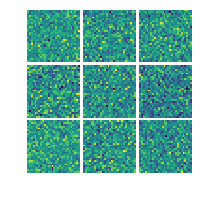

2018-05-18 19:54:08 iteration 100/50000: current training loss = 3.413470 (=2.633172+0.667696+0.112603)


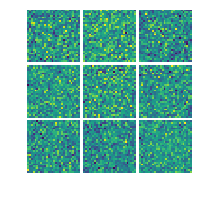

2018-05-18 19:54:45 iteration 200/50000: current training loss = 4.568405 (=1.608929+0.198172+2.761305)


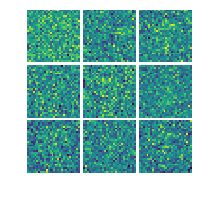

2018-05-18 19:55:20 iteration 300/50000: current training loss = 3.370217 (=0.765375+0.206027+2.398815)


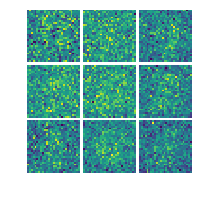

2018-05-18 19:55:53 iteration 400/50000: current training loss = 3.141003 (=0.681310+0.204276+2.255417)


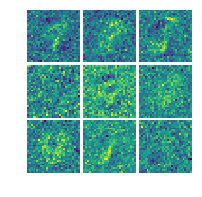

2018-05-18 19:56:27 iteration 500/50000: current training loss = 2.167274 (=0.436212+0.229108+1.501953)


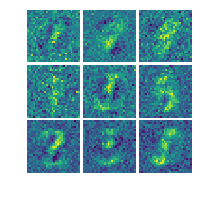

2018-05-18 19:57:02 iteration 600/50000: current training loss = 2.721627 (=0.350859+0.225555+2.145212)


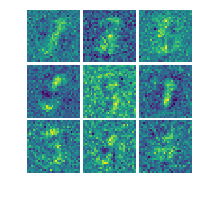

2018-05-18 19:57:38 iteration 700/50000: current training loss = 2.218393 (=0.334612+0.270184+1.613597)


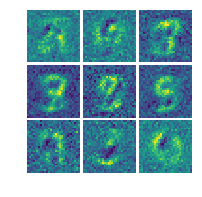

2018-05-18 19:58:14 iteration 800/50000: current training loss = 2.975479 (=0.264694+0.224311+2.486474)


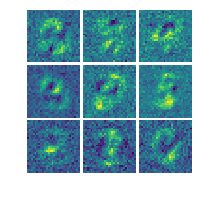

2018-05-18 19:58:50 iteration 900/50000: current training loss = 3.237738 (=0.229083+0.218275+2.790380)


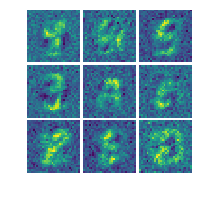

2018-05-18 19:59:26 iteration 1000/50000: current training loss = 3.244236 (=0.184521+0.191926+2.867789)


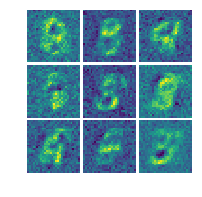

2018-05-18 20:00:03 iteration 1100/50000: current training loss = 3.938648 (=0.176530+0.183811+3.578307)


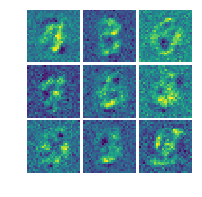

2018-05-18 20:00:40 iteration 1200/50000: current training loss = 4.863730 (=0.162860+0.173983+4.526887)


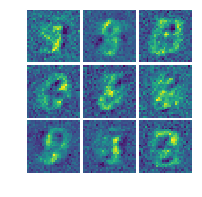

2018-05-18 20:01:16 iteration 1300/50000: current training loss = 4.534050 (=0.168928+0.153651+4.211470)


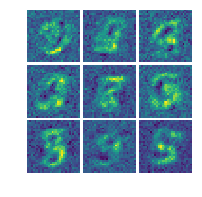

2018-05-18 20:01:51 iteration 1400/50000: current training loss = 4.462420 (=0.172800+0.164164+4.125457)


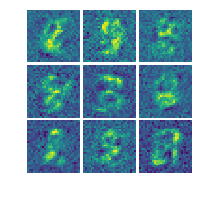

2018-05-18 20:02:27 iteration 1500/50000: current training loss = 4.758828 (=0.199200+0.160652+4.398976)


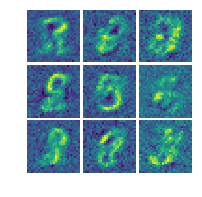

2018-05-18 20:03:05 iteration 1600/50000: current training loss = 4.705871 (=0.220822+0.164966+4.320083)


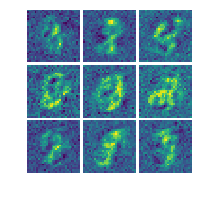

2018-05-18 20:03:43 iteration 1700/50000: current training loss = 5.639851 (=0.259720+0.173300+5.206831)


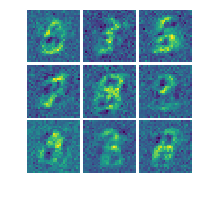

2018-05-18 20:04:20 iteration 1800/50000: current training loss = 4.279149 (=0.271324+0.181977+3.825848)


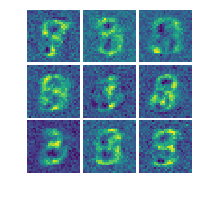

2018-05-18 20:04:59 iteration 1900/50000: current training loss = 5.525476 (=0.234936+0.180883+5.109656)


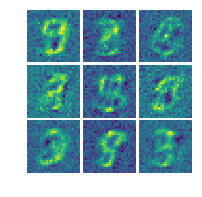

2018-05-18 20:05:37 iteration 2000/50000: current training loss = 3.904774 (=0.254501+0.195971+3.454303)


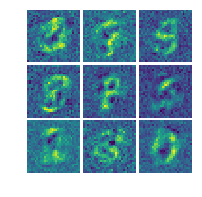

2018-05-18 20:06:16 iteration 2100/50000: current training loss = 5.404384 (=0.244386+0.177718+4.982279)


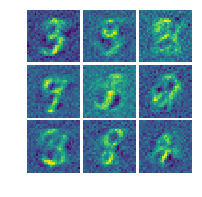

2018-05-18 20:06:54 iteration 2200/50000: current training loss = 5.210464 (=0.267453+0.178623+4.764388)


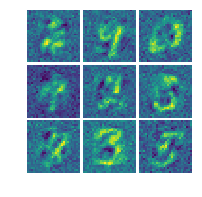

2018-05-18 20:07:32 iteration 2300/50000: current training loss = 5.029195 (=0.202206+0.190589+4.636400)


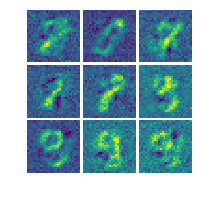

2018-05-18 20:08:09 iteration 2400/50000: current training loss = 4.496224 (=0.223919+0.187941+4.084364)


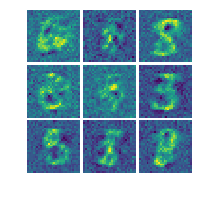

2018-05-18 20:08:47 iteration 2500/50000: current training loss = 5.319166 (=0.254676+0.181245+4.883245)


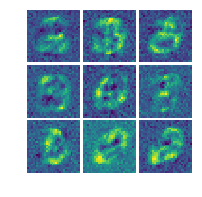

2018-05-18 20:09:25 iteration 2600/50000: current training loss = 4.577090 (=0.267854+0.204245+4.104991)


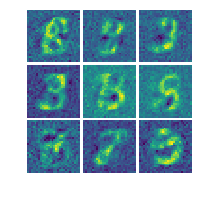

2018-05-18 20:10:04 iteration 2700/50000: current training loss = 5.347718 (=0.326321+0.217102+4.804295)


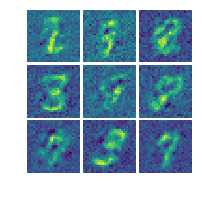

2018-05-18 20:10:40 iteration 2800/50000: current training loss = 5.701825 (=0.227520+0.177831+5.296474)


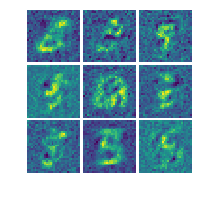

2018-05-18 20:11:16 iteration 2900/50000: current training loss = 4.965465 (=0.229473+0.196296+4.539695)


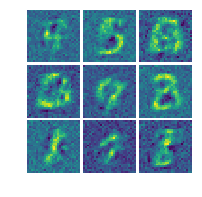

2018-05-18 20:11:56 iteration 3000/50000: current training loss = 5.649508 (=0.207356+0.175754+5.266398)


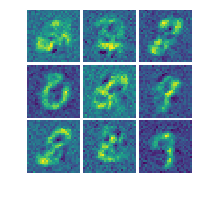

2018-05-18 20:12:33 iteration 3100/50000: current training loss = 5.679607 (=0.240337+0.192500+5.246769)


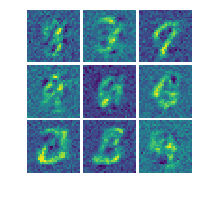

2018-05-18 20:13:08 iteration 3200/50000: current training loss = 4.962824 (=0.199554+0.195953+4.567317)


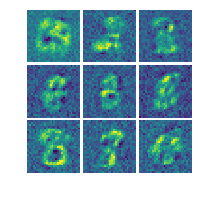

2018-05-18 20:13:44 iteration 3300/50000: current training loss = 5.445405 (=0.352104+0.181080+4.912221)


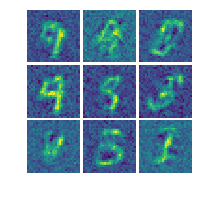

2018-05-18 20:14:18 iteration 3400/50000: current training loss = 5.575704 (=0.229459+0.218624+5.127620)


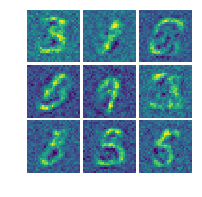

2018-05-18 20:14:51 iteration 3500/50000: current training loss = 5.611632 (=0.241492+0.148329+5.221812)


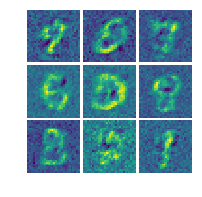

2018-05-18 20:15:25 iteration 3600/50000: current training loss = 5.939396 (=0.203233+0.158240+5.577922)


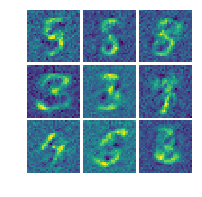

2018-05-18 20:16:01 iteration 3700/50000: current training loss = 5.574851 (=0.198382+0.166561+5.209908)


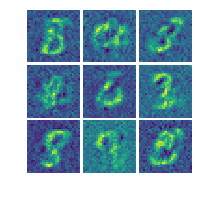

2018-05-18 20:16:35 iteration 3800/50000: current training loss = 6.771142 (=0.199079+0.163713+6.408350)


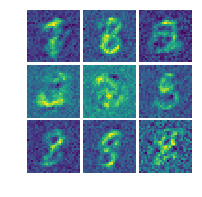

2018-05-18 20:17:10 iteration 3900/50000: current training loss = 7.575370 (=0.198426+0.128069+7.248876)


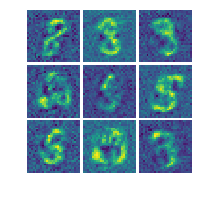

2018-05-18 20:17:45 iteration 4000/50000: current training loss = 6.024744 (=0.178653+0.164324+5.681767)


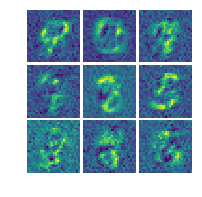

2018-05-18 20:18:20 iteration 4100/50000: current training loss = 6.358875 (=0.222309+0.156859+5.979707)


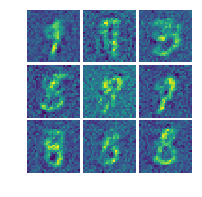

2018-05-18 20:18:55 iteration 4200/50000: current training loss = 6.424264 (=0.193229+0.181402+6.049633)


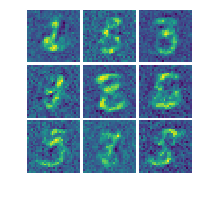

2018-05-18 20:19:29 iteration 4300/50000: current training loss = 8.024547 (=0.188227+0.133436+7.702883)


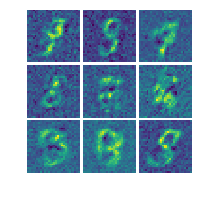

2018-05-18 20:20:04 iteration 4400/50000: current training loss = 7.067923 (=0.215843+0.132001+6.720078)


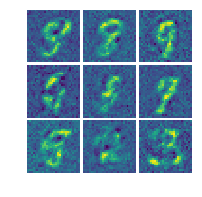

2018-05-18 20:20:39 iteration 4500/50000: current training loss = 6.762650 (=0.184282+0.160437+6.417931)


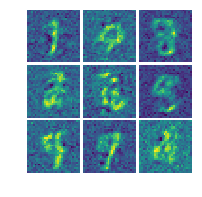

2018-05-18 20:21:15 iteration 4600/50000: current training loss = 7.951046 (=0.261823+0.131425+7.557797)


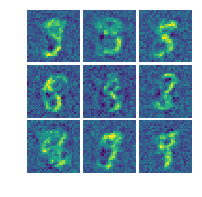

2018-05-18 20:21:50 iteration 4700/50000: current training loss = 8.161240 (=0.206721+0.138992+7.815526)


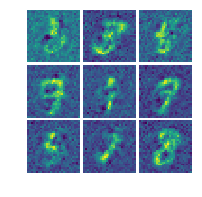

2018-05-18 20:22:25 iteration 4800/50000: current training loss = 6.677311 (=0.216658+0.146247+6.314406)


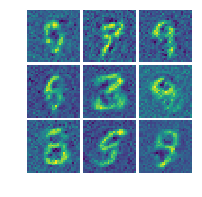

2018-05-18 20:23:00 iteration 4900/50000: current training loss = 6.984285 (=0.249929+0.150985+6.583371)


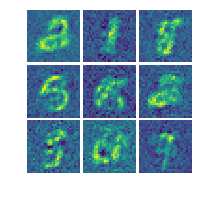

2018-05-18 20:23:35 iteration 5000/50000: current training loss = 7.077786 (=0.206227+0.155374+6.716186)


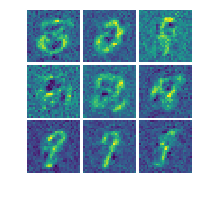

2018-05-18 20:24:09 iteration 5100/50000: current training loss = 7.561802 (=0.214516+0.133724+7.213563)


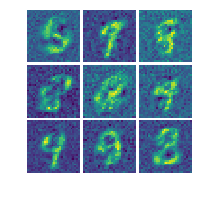

2018-05-18 20:24:45 iteration 5200/50000: current training loss = 6.719501 (=0.203814+0.160428+6.355259)


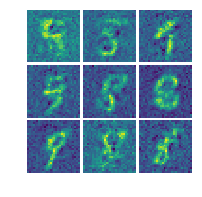

2018-05-18 20:25:19 iteration 5300/50000: current training loss = 5.758089 (=0.233958+0.190582+5.333549)


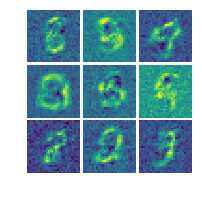

2018-05-18 20:25:54 iteration 5400/50000: current training loss = 8.639129 (=0.238524+0.134015+8.266589)


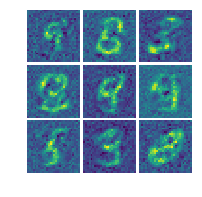

2018-05-18 20:26:28 iteration 5500/50000: current training loss = 9.576447 (=0.226391+0.109791+9.240264)


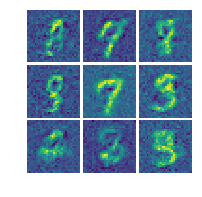

2018-05-18 20:27:04 iteration 5600/50000: current training loss = 8.899144 (=0.250264+0.106413+8.542467)


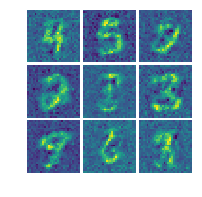

2018-05-18 20:27:39 iteration 5700/50000: current training loss = 8.447046 (=0.254819+0.144035+8.048192)


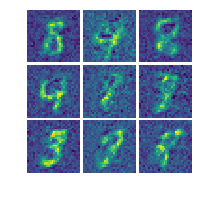

2018-05-18 20:28:13 iteration 5800/50000: current training loss = 8.065307 (=0.239840+0.130222+7.695245)


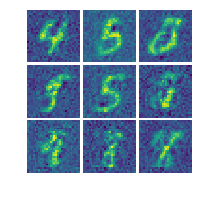

2018-05-18 20:28:46 iteration 5900/50000: current training loss = 6.970437 (=0.226924+0.145910+6.597603)


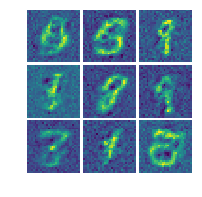

2018-05-18 20:29:19 iteration 6000/50000: current training loss = 10.767244 (=0.255634+0.100601+10.411009)


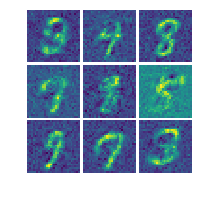

2018-05-18 20:29:54 iteration 6100/50000: current training loss = 8.491113 (=0.252521+0.135181+8.103412)


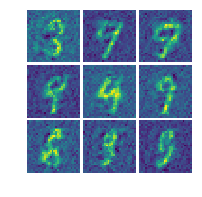

2018-05-18 20:30:28 iteration 6200/50000: current training loss = 7.531486 (=0.252373+0.134720+7.144392)


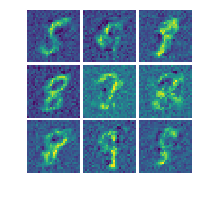

2018-05-18 20:31:03 iteration 6300/50000: current training loss = 8.374789 (=0.289271+0.141942+7.943577)


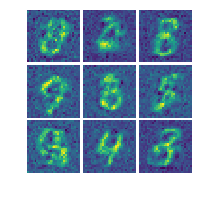

2018-05-18 20:31:38 iteration 6400/50000: current training loss = 8.675942 (=0.275070+0.120097+8.280775)


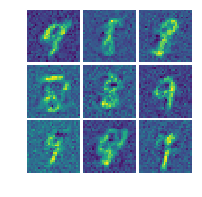

2018-05-18 20:32:13 iteration 6500/50000: current training loss = 8.502147 (=0.272698+0.107783+8.121666)


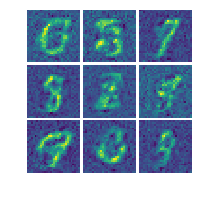

2018-05-18 20:32:48 iteration 6600/50000: current training loss = 9.166821 (=0.272948+0.129654+8.764219)


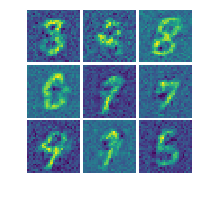

2018-05-18 20:33:24 iteration 6700/50000: current training loss = 8.003281 (=0.290359+0.136377+7.576545)


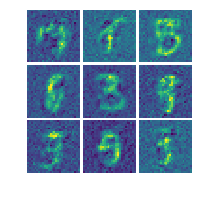

2018-05-18 20:33:59 iteration 6800/50000: current training loss = 11.861260 (=0.321154+0.091341+11.448766)


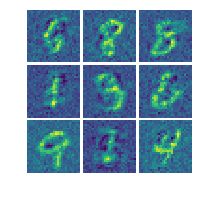

2018-05-18 20:34:36 iteration 6900/50000: current training loss = 11.004033 (=0.303868+0.117541+10.582623)


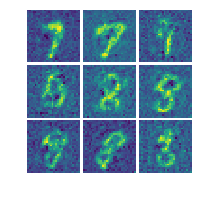

2018-05-18 20:35:12 iteration 7000/50000: current training loss = 7.749817 (=0.300660+0.134119+7.315038)


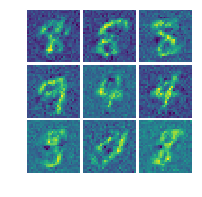

2018-05-18 20:35:46 iteration 7100/50000: current training loss = 8.313177 (=0.323141+0.112573+7.877463)


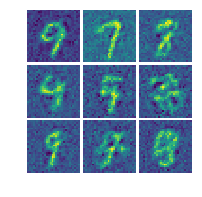

2018-05-18 20:36:21 iteration 7200/50000: current training loss = 7.781867 (=0.306068+0.123398+7.352400)


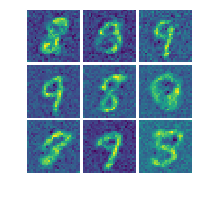

2018-05-18 20:36:55 iteration 7300/50000: current training loss = 9.187469 (=0.295740+0.101120+8.790608)


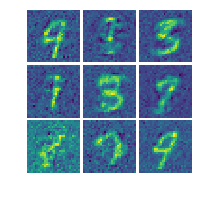

2018-05-18 20:37:29 iteration 7400/50000: current training loss = 9.783691 (=0.269510+0.121607+9.392575)


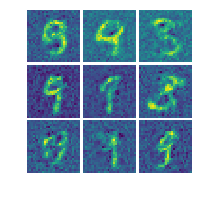

2018-05-18 20:38:04 iteration 7500/50000: current training loss = 10.184268 (=0.303579+0.124489+9.756200)


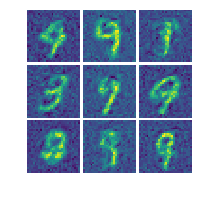

2018-05-18 20:38:38 iteration 7600/50000: current training loss = 8.404113 (=0.288948+0.113549+8.001616)


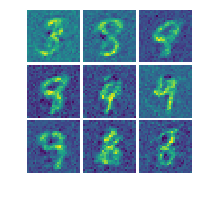

2018-05-18 20:39:12 iteration 7700/50000: current training loss = 10.990770 (=0.320767+0.095684+10.574319)


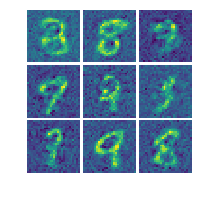

2018-05-18 20:39:46 iteration 7800/50000: current training loss = 11.161826 (=0.304999+0.081395+10.775432)


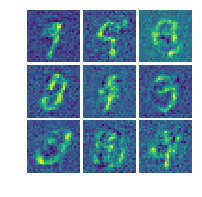

2018-05-18 20:40:22 iteration 7900/50000: current training loss = 10.956570 (=0.316100+0.084585+10.555884)


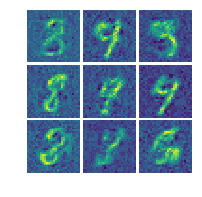

2018-05-18 20:40:55 iteration 8000/50000: current training loss = 9.958723 (=0.330422+0.113331+9.514970)


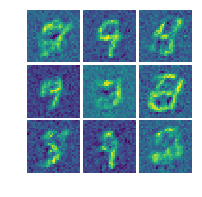

2018-05-18 20:41:30 iteration 8100/50000: current training loss = 9.632488 (=0.325028+0.101375+9.206085)


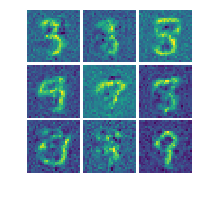

2018-05-18 20:42:05 iteration 8200/50000: current training loss = 9.283028 (=0.330979+0.111141+8.840907)


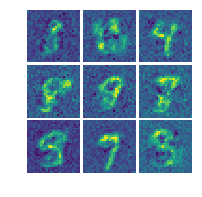

2018-05-18 20:42:40 iteration 8300/50000: current training loss = 9.626371 (=0.307995+0.094165+9.224212)


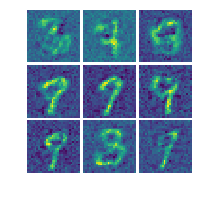

2018-05-18 20:43:14 iteration 8400/50000: current training loss = 10.491062 (=0.320367+0.106701+10.063994)


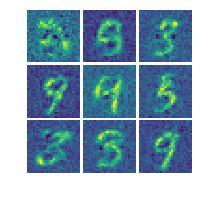

2018-05-18 20:43:50 iteration 8500/50000: current training loss = 10.078246 (=0.319692+0.116147+9.642407)


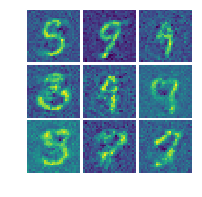

2018-05-18 20:44:26 iteration 8600/50000: current training loss = 10.798535 (=0.375715+0.123854+10.298966)


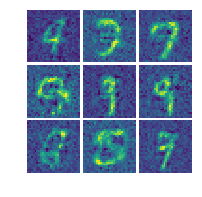

2018-05-18 20:45:01 iteration 8700/50000: current training loss = 10.420528 (=0.346566+0.088773+9.985189)


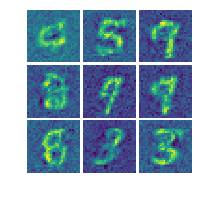

2018-05-18 20:45:36 iteration 8800/50000: current training loss = 8.402205 (=0.333237+0.099902+7.969066)


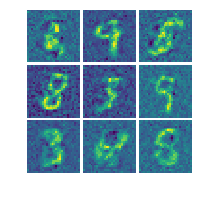

2018-05-18 20:46:10 iteration 8900/50000: current training loss = 9.361719 (=0.306048+0.119631+8.936040)


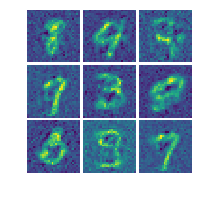

2018-05-18 20:46:44 iteration 9000/50000: current training loss = 9.850309 (=0.302232+0.085903+9.462175)


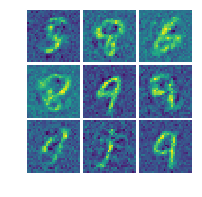

2018-05-18 20:47:20 iteration 9100/50000: current training loss = 9.035126 (=0.318294+0.112571+8.604260)


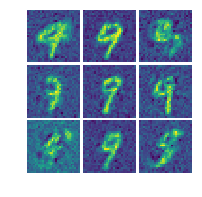

2018-05-18 20:47:55 iteration 9200/50000: current training loss = 14.321330 (=0.361083+0.068681+13.891566)


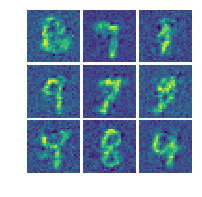

2018-05-18 20:48:30 iteration 9300/50000: current training loss = 8.262091 (=0.287757+0.102189+7.872145)


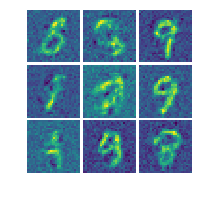

2018-05-18 20:49:03 iteration 9400/50000: current training loss = 9.040072 (=0.299653+0.111235+8.629184)


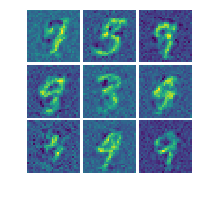

2018-05-18 20:49:38 iteration 9500/50000: current training loss = 11.745829 (=0.310997+0.069043+11.365788)


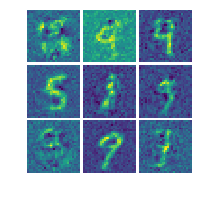

2018-05-18 20:50:13 iteration 9600/50000: current training loss = 8.418833 (=0.312822+0.113850+7.992160)


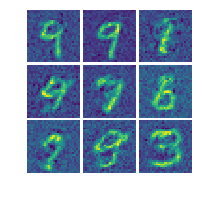

2018-05-18 20:50:47 iteration 9700/50000: current training loss = 8.989958 (=0.311405+0.112335+8.566217)


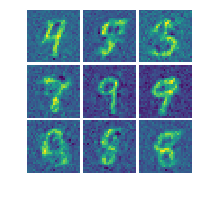

2018-05-18 20:51:21 iteration 9800/50000: current training loss = 10.384655 (=0.335287+0.092680+9.956688)


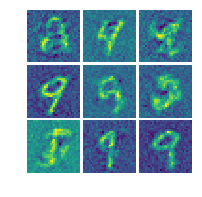

2018-05-18 20:51:55 iteration 9900/50000: current training loss = 7.318237 (=0.304477+0.118352+6.895408)


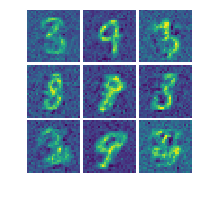

2018-05-18 20:52:29 iteration 10000/50000: current training loss = 8.743295 (=0.310041+0.101649+8.331605)


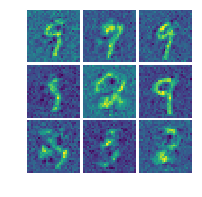

2018-05-18 20:53:02 iteration 10100/50000: current training loss = 11.743904 (=0.349903+0.101635+11.292365)


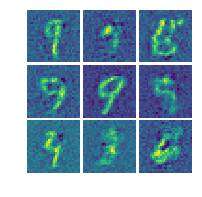

2018-05-18 20:53:37 iteration 10200/50000: current training loss = 9.578036 (=0.316365+0.097176+9.164495)


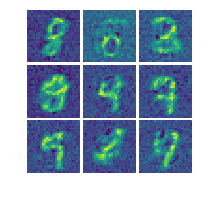

2018-05-18 20:54:10 iteration 10300/50000: current training loss = 14.867402 (=0.356773+0.058368+14.452261)


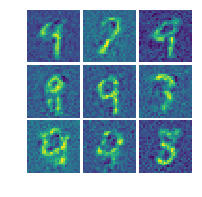

2018-05-18 20:54:44 iteration 10400/50000: current training loss = 13.600850 (=0.362089+0.074797+13.163964)


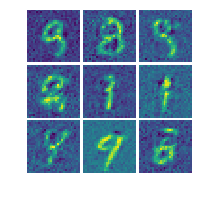

2018-05-18 20:55:19 iteration 10500/50000: current training loss = 10.810342 (=0.326385+0.076212+10.407743)


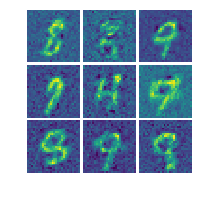

2018-05-18 20:55:53 iteration 10600/50000: current training loss = 10.430367 (=0.311026+0.078880+10.040461)


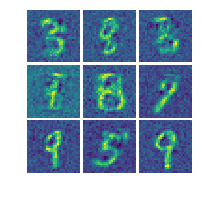

2018-05-18 20:56:28 iteration 10700/50000: current training loss = 9.836313 (=0.311997+0.092682+9.431634)


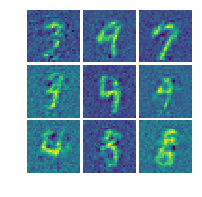

2018-05-18 20:57:03 iteration 10800/50000: current training loss = 12.333020 (=0.328919+0.095835+11.908266)


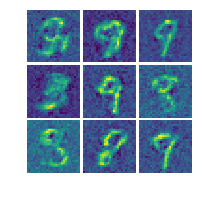

2018-05-18 20:57:37 iteration 10900/50000: current training loss = 11.378577 (=0.354817+0.098178+10.925583)


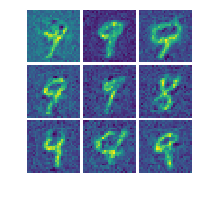

2018-05-18 20:58:13 iteration 11000/50000: current training loss = 14.068626 (=0.347492+0.083514+13.637621)


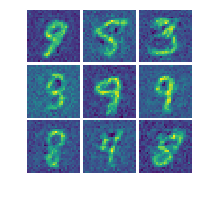

2018-05-18 20:58:47 iteration 11100/50000: current training loss = 8.991160 (=0.310874+0.097919+8.582367)


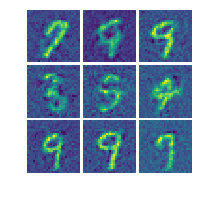

2018-05-18 20:59:23 iteration 11200/50000: current training loss = 10.857652 (=0.319474+0.095366+10.442811)


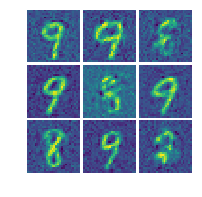

2018-05-18 21:00:01 iteration 11300/50000: current training loss = 10.973810 (=0.366203+0.100723+10.506885)


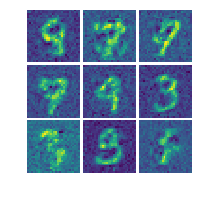

2018-05-18 21:00:41 iteration 11400/50000: current training loss = 9.884790 (=0.328818+0.077389+9.478582)


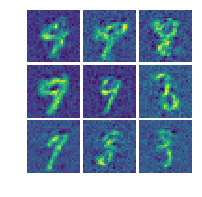

2018-05-18 21:01:19 iteration 11500/50000: current training loss = 13.135761 (=0.365983+0.061938+12.707839)


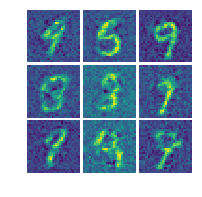

2018-05-18 21:01:57 iteration 11600/50000: current training loss = 13.597322 (=0.310007+0.055112+13.232203)


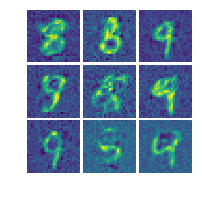

2018-05-18 21:02:33 iteration 11700/50000: current training loss = 9.963347 (=0.284162+0.075841+9.603345)


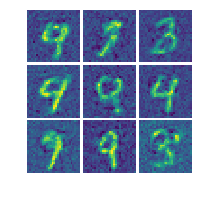

2018-05-18 21:03:13 iteration 11800/50000: current training loss = 17.675499 (=0.422560+0.062629+17.190310)


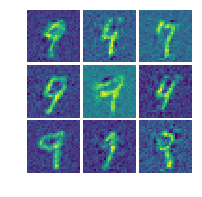

2018-05-18 21:03:48 iteration 11900/50000: current training loss = 9.729889 (=0.300233+0.087884+9.341771)


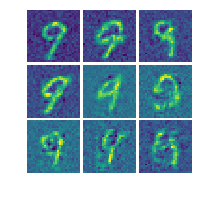

2018-05-18 21:04:23 iteration 12000/50000: current training loss = 14.252522 (=0.259540+0.057498+13.935484)


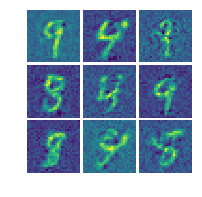

2018-05-18 21:04:59 iteration 12100/50000: current training loss = 13.879511 (=0.337946+0.068877+13.472687)


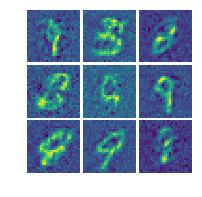

2018-05-18 21:05:34 iteration 12200/50000: current training loss = 12.874810 (=0.305231+0.054488+12.515091)


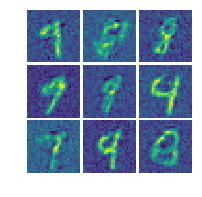

2018-05-18 21:06:09 iteration 12300/50000: current training loss = 9.469540 (=0.462760+0.101661+8.905118)


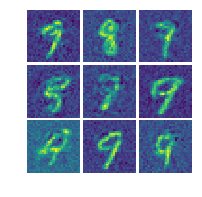

2018-05-18 21:06:44 iteration 12400/50000: current training loss = 16.662052 (=0.380640+0.054786+16.226627)


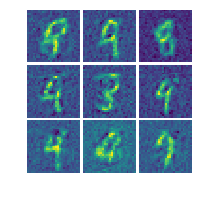

2018-05-18 21:07:19 iteration 12500/50000: current training loss = 9.034952 (=0.319365+0.098916+8.616671)


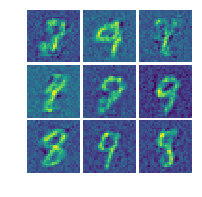

2018-05-18 21:07:54 iteration 12600/50000: current training loss = 11.898093 (=0.390329+0.087413+11.420351)


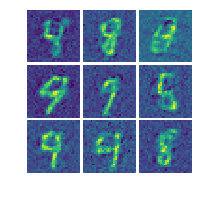

2018-05-18 21:08:28 iteration 12700/50000: current training loss = 14.632735 (=0.335397+0.051799+14.245540)


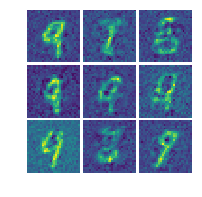

2018-05-18 21:09:03 iteration 12800/50000: current training loss = 17.008081 (=0.554875+0.062742+16.390465)


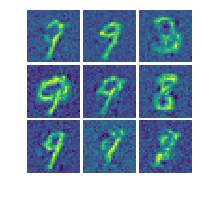

2018-05-18 21:09:36 iteration 12900/50000: current training loss = 12.449249 (=0.380691+0.065513+12.003045)


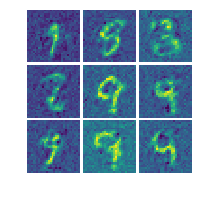

2018-05-18 21:10:11 iteration 13000/50000: current training loss = 10.756713 (=0.595612+0.081540+10.079561)


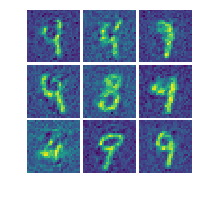

2018-05-18 21:10:46 iteration 13100/50000: current training loss = 9.764452 (=0.281842+0.087237+9.395373)


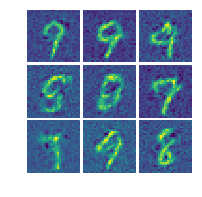

2018-05-18 21:11:20 iteration 13200/50000: current training loss = 12.089766 (=0.385682+0.064041+11.640043)


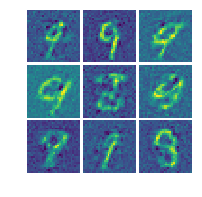

2018-05-18 21:11:58 iteration 13300/50000: current training loss = 12.065875 (=0.315329+0.074877+11.675669)


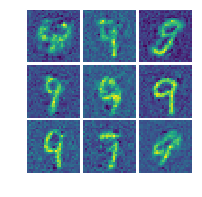

2018-05-18 21:12:37 iteration 13400/50000: current training loss = 9.952820 (=0.343399+0.083045+9.526376)


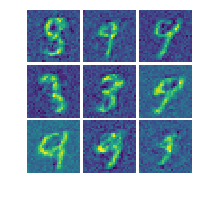

2018-05-18 21:13:17 iteration 13500/50000: current training loss = 8.599940 (=0.384594+0.096892+8.118454)


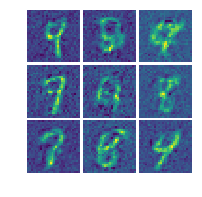

2018-05-18 21:13:57 iteration 13600/50000: current training loss = 11.472601 (=0.383647+0.085167+11.003787)


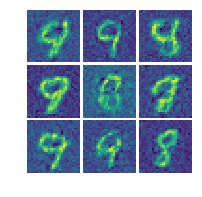

2018-05-18 21:14:37 iteration 13700/50000: current training loss = 14.411325 (=0.577951+0.066573+13.766801)


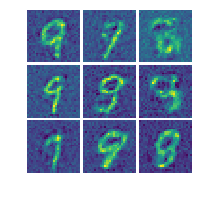

2018-05-18 21:15:17 iteration 13800/50000: current training loss = 12.441941 (=0.352052+0.087944+12.001945)


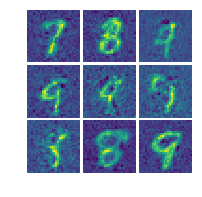

2018-05-18 21:15:57 iteration 13900/50000: current training loss = 11.800489 (=0.499557+0.059044+11.241888)


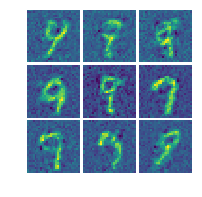

2018-05-18 21:16:37 iteration 14000/50000: current training loss = 12.355258 (=0.467875+0.068938+11.818445)


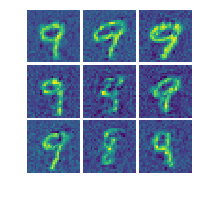

2018-05-18 21:17:16 iteration 14100/50000: current training loss = 13.033570 (=0.414269+0.055620+12.563682)


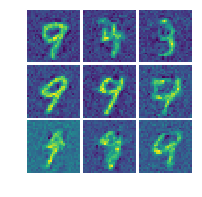

2018-05-18 21:17:56 iteration 14200/50000: current training loss = 19.153708 (=0.404260+0.060151+18.689297)


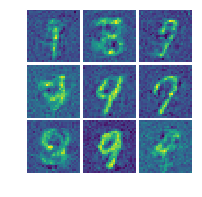

2018-05-18 21:18:34 iteration 14300/50000: current training loss = 13.209171 (=0.387273+0.069176+12.752722)


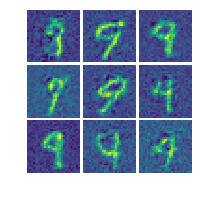

2018-05-18 21:19:13 iteration 14400/50000: current training loss = 15.364148 (=0.360818+0.048491+14.954839)


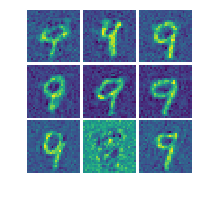

2018-05-18 21:19:51 iteration 14500/50000: current training loss = 9.873368 (=0.346982+0.081469+9.444918)


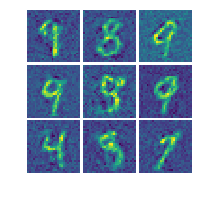

2018-05-18 21:20:30 iteration 14600/50000: current training loss = 11.469446 (=0.338514+0.068134+11.062798)


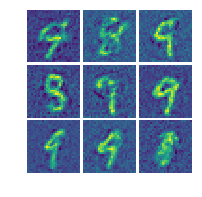

2018-05-18 21:21:10 iteration 14700/50000: current training loss = 8.215397 (=0.708443+0.102279+7.404675)


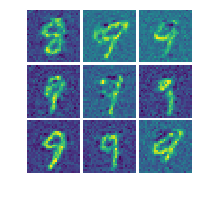

2018-05-18 21:21:50 iteration 14800/50000: current training loss = 10.421494 (=0.325009+0.079434+10.017051)


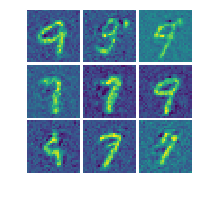

2018-05-18 21:22:29 iteration 14900/50000: current training loss = 13.712980 (=0.356371+0.060023+13.296587)


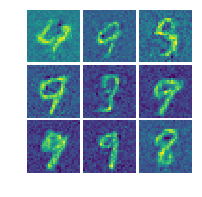

2018-05-18 21:23:10 iteration 15000/50000: current training loss = 9.882232 (=0.466443+0.077197+9.338592)


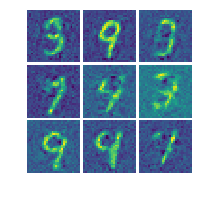

2018-05-18 21:23:49 iteration 15100/50000: current training loss = 12.056910 (=0.424106+0.072594+11.560209)


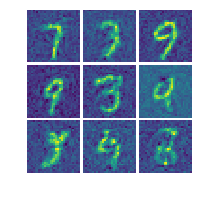

2018-05-18 21:24:30 iteration 15200/50000: current training loss = 10.942634 (=0.342890+0.065300+10.534444)


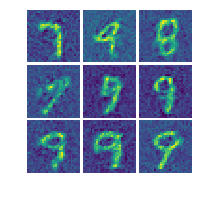

2018-05-18 21:25:09 iteration 15300/50000: current training loss = 11.715669 (=0.349053+0.073864+11.292750)


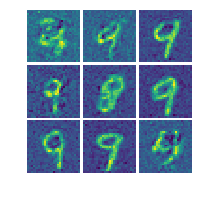

2018-05-18 21:25:48 iteration 15400/50000: current training loss = 18.352715 (=0.377320+0.054456+17.920938)


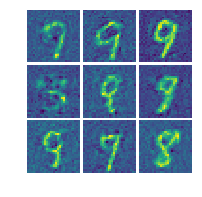

2018-05-18 21:26:27 iteration 15500/50000: current training loss = 11.865657 (=0.388710+0.075779+11.401168)


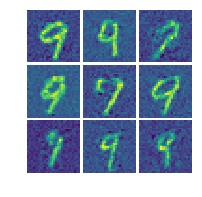

2018-05-18 21:27:07 iteration 15600/50000: current training loss = 13.701066 (=0.351106+0.073446+13.276514)


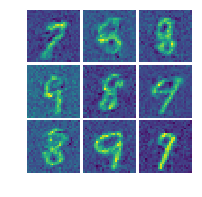

2018-05-18 21:27:46 iteration 15700/50000: current training loss = 16.201925 (=0.425690+0.061741+15.714495)


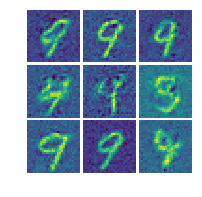

2018-05-18 21:28:25 iteration 15800/50000: current training loss = 12.676247 (=0.478678+0.050785+12.146783)


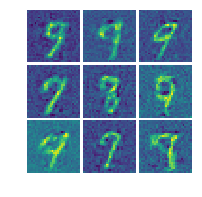

2018-05-18 21:29:04 iteration 15900/50000: current training loss = 10.479810 (=0.372493+0.074968+10.032349)


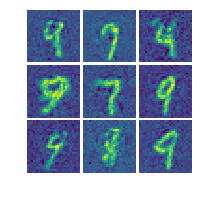

2018-05-18 21:29:44 iteration 16000/50000: current training loss = 10.745033 (=0.369717+0.082411+10.292906)


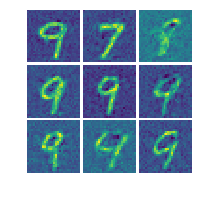

2018-05-18 21:30:23 iteration 16100/50000: current training loss = 13.259698 (=0.399533+0.071387+12.788778)


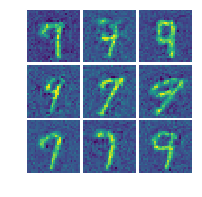

2018-05-18 21:31:03 iteration 16200/50000: current training loss = 11.520462 (=0.441021+0.074114+11.005327)


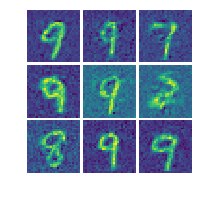

2018-05-18 21:31:42 iteration 16300/50000: current training loss = 10.299774 (=0.401162+0.074088+9.824524)


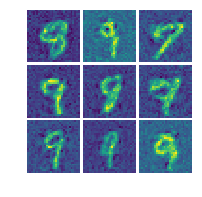

2018-05-18 21:32:22 iteration 16400/50000: current training loss = 11.486047 (=0.476786+0.088164+10.921097)


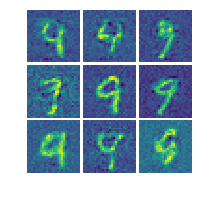

2018-05-18 21:33:02 iteration 16500/50000: current training loss = 14.712749 (=0.404403+0.056315+14.252031)


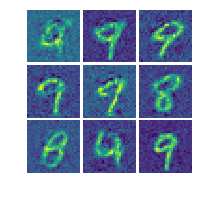

2018-05-18 21:33:41 iteration 16600/50000: current training loss = 11.457964 (=0.462284+0.075841+10.919839)


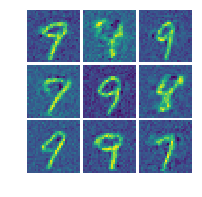

2018-05-18 21:34:20 iteration 16700/50000: current training loss = 12.139164 (=0.397401+0.074916+11.666846)


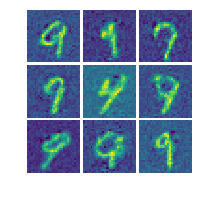

2018-05-18 21:34:59 iteration 16800/50000: current training loss = 12.064860 (=0.508825+0.077387+11.478648)


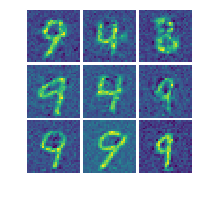

2018-05-18 21:35:39 iteration 16900/50000: current training loss = 12.392566 (=0.447905+0.070520+11.874141)


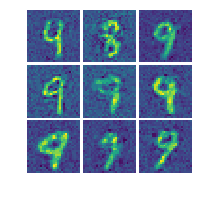

2018-05-18 21:36:19 iteration 17000/50000: current training loss = 15.299301 (=0.516496+0.053108+14.729697)


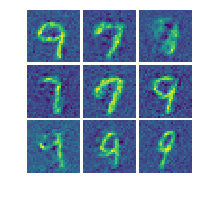

2018-05-18 21:36:58 iteration 17100/50000: current training loss = 11.690431 (=0.523223+0.061182+11.106025)


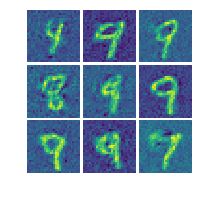

2018-05-18 21:37:37 iteration 17200/50000: current training loss = 13.898978 (=0.459281+0.062193+13.377503)


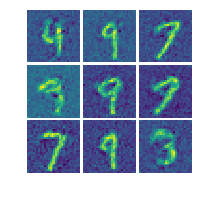

2018-05-18 21:38:17 iteration 17300/50000: current training loss = 12.083401 (=0.479251+0.061729+11.542421)


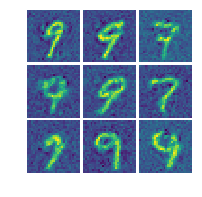

2018-05-18 21:38:56 iteration 17400/50000: current training loss = 11.573009 (=0.453366+0.057271+11.062372)


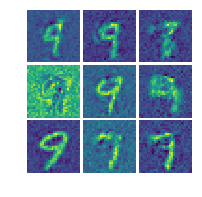

2018-05-18 21:39:36 iteration 17500/50000: current training loss = 13.757144 (=0.470523+0.074843+13.211777)


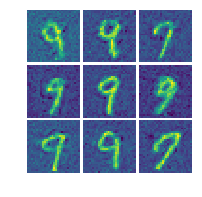

2018-05-18 21:40:15 iteration 17600/50000: current training loss = 10.799996 (=0.460278+0.072223+10.267495)


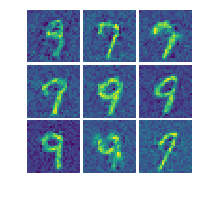

2018-05-18 21:40:55 iteration 17700/50000: current training loss = 10.695740 (=0.434711+0.087183+10.173846)


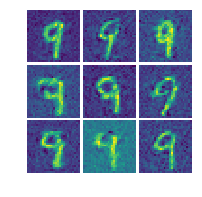

2018-05-18 21:41:35 iteration 17800/50000: current training loss = 10.809368 (=0.421438+0.069877+10.318052)


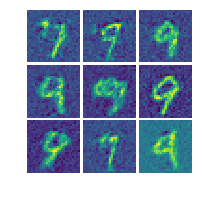

2018-05-18 21:42:14 iteration 17900/50000: current training loss = 10.800331 (=0.446996+0.074177+10.279158)


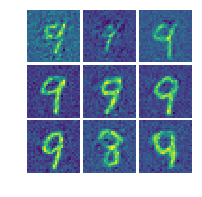

2018-05-18 21:42:54 iteration 18000/50000: current training loss = 12.868785 (=0.468501+0.060600+12.339684)


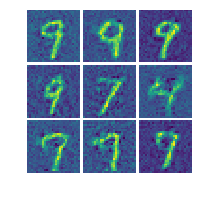

2018-05-18 21:43:33 iteration 18100/50000: current training loss = 12.076412 (=0.431437+0.068070+11.576904)


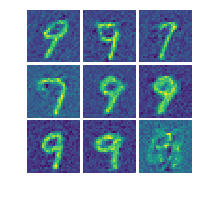

2018-05-18 21:44:13 iteration 18200/50000: current training loss = 14.864824 (=0.495518+0.051369+14.317937)


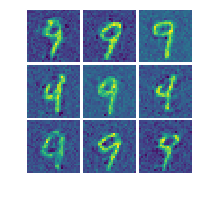

2018-05-18 21:44:53 iteration 18300/50000: current training loss = 13.596382 (=0.526809+0.056798+13.012774)


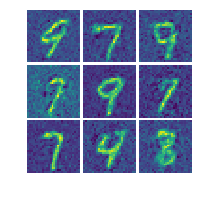

2018-05-18 21:45:32 iteration 18400/50000: current training loss = 14.415732 (=0.508816+0.063757+13.843160)


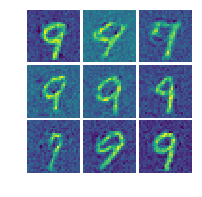

2018-05-18 21:46:10 iteration 18500/50000: current training loss = 12.195483 (=0.485953+0.069026+11.640504)


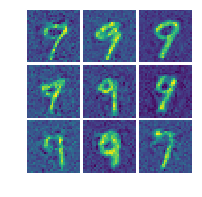

2018-05-18 21:46:50 iteration 18600/50000: current training loss = 10.109521 (=0.416775+0.079487+9.613259)


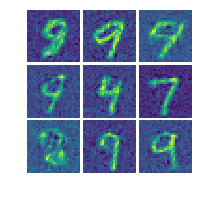

2018-05-18 21:47:30 iteration 18700/50000: current training loss = 12.290956 (=0.455328+0.083958+11.751670)


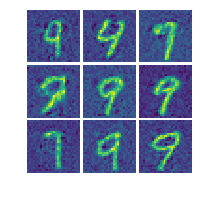

2018-05-18 21:48:09 iteration 18800/50000: current training loss = 17.825005 (=0.464903+0.053592+17.306509)


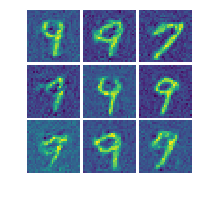

2018-05-18 21:48:49 iteration 18900/50000: current training loss = 12.742999 (=0.436815+0.067242+12.238942)


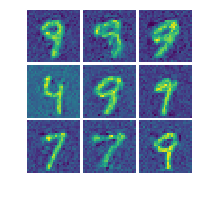

2018-05-18 21:49:29 iteration 19000/50000: current training loss = 11.487626 (=0.418822+0.082339+10.986465)


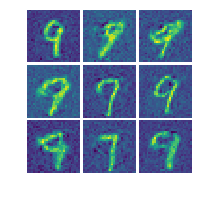

2018-05-18 21:50:09 iteration 19100/50000: current training loss = 10.198227 (=0.432896+0.085142+9.680189)


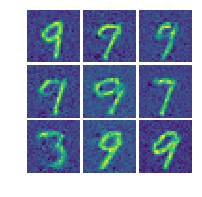

2018-05-18 21:50:49 iteration 19200/50000: current training loss = 13.875286 (=0.553646+0.061079+13.260561)


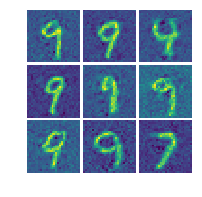

2018-05-18 21:51:29 iteration 19300/50000: current training loss = 13.151659 (=0.540001+0.056706+12.554952)


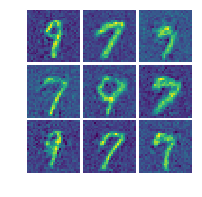

2018-05-18 21:52:09 iteration 19400/50000: current training loss = 14.703806 (=0.443649+0.055389+14.204767)


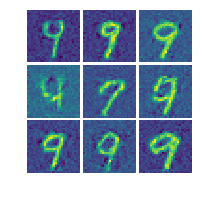

2018-05-18 21:52:48 iteration 19500/50000: current training loss = 11.797845 (=0.498908+0.085026+11.213911)


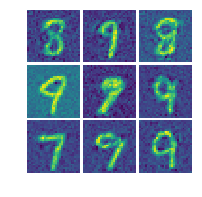

2018-05-18 21:53:28 iteration 19600/50000: current training loss = 13.286349 (=0.486103+0.075493+12.724753)


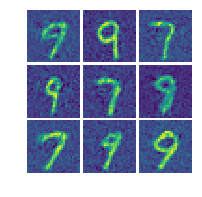

2018-05-18 21:54:08 iteration 19700/50000: current training loss = 13.365877 (=0.560879+0.066054+12.738944)


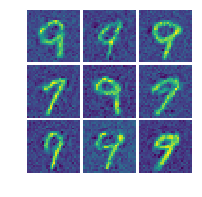

2018-05-18 21:54:49 iteration 19800/50000: current training loss = 18.461174 (=0.523446+0.050591+17.887136)


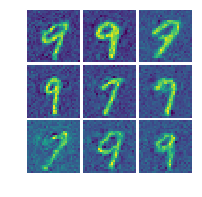

2018-05-18 21:55:29 iteration 19900/50000: current training loss = 11.248211 (=0.473336+0.071046+10.703830)


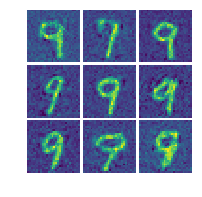

2018-05-18 21:56:08 iteration 20000/50000: current training loss = 12.345497 (=0.532255+0.071892+11.741350)


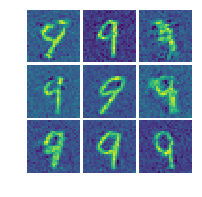

2018-05-18 21:56:47 iteration 20100/50000: current training loss = 11.267752 (=0.470742+0.073429+10.723579)


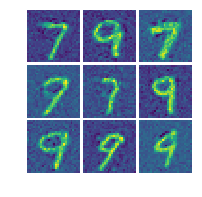

2018-05-18 21:57:27 iteration 20200/50000: current training loss = 13.145962 (=0.597267+0.055073+12.493623)


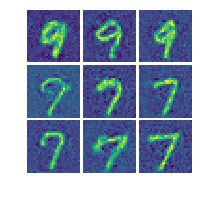

2018-05-18 21:58:06 iteration 20300/50000: current training loss = 10.583804 (=0.475325+0.076540+10.031939)


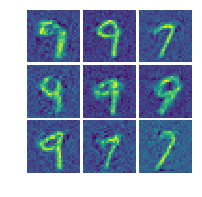

2018-05-18 21:58:46 iteration 20400/50000: current training loss = 12.594422 (=0.470035+0.060443+12.063944)


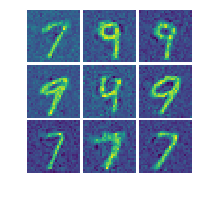

2018-05-18 21:59:25 iteration 20500/50000: current training loss = 14.283004 (=0.488173+0.053963+13.740869)


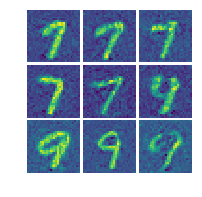

2018-05-18 22:00:04 iteration 20600/50000: current training loss = 13.287434 (=0.487273+0.057247+12.742912)


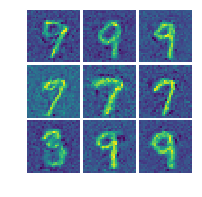

2018-05-18 22:00:42 iteration 20700/50000: current training loss = 11.917646 (=0.435451+0.068093+11.414102)


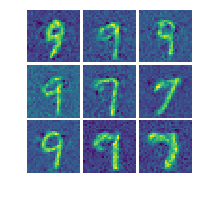

2018-05-18 22:01:21 iteration 20800/50000: current training loss = 11.571404 (=0.488027+0.066678+11.016699)


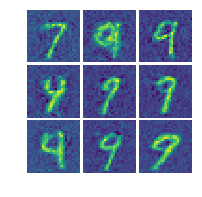

2018-05-18 22:02:01 iteration 20900/50000: current training loss = 12.831912 (=0.451209+0.061533+12.319170)


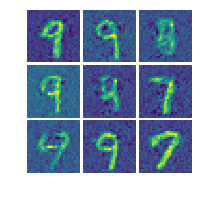

2018-05-18 22:02:41 iteration 21000/50000: current training loss = 12.491293 (=0.433618+0.062426+11.995249)


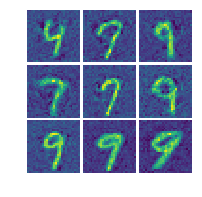

2018-05-18 22:03:20 iteration 21100/50000: current training loss = 12.709659 (=0.423299+0.066661+12.219698)


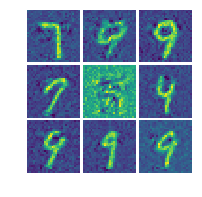

2018-05-18 22:03:59 iteration 21200/50000: current training loss = 19.066792 (=0.577724+0.049638+18.439428)


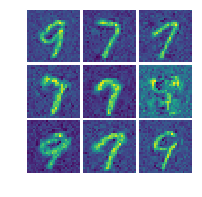

2018-05-18 22:04:39 iteration 21300/50000: current training loss = 12.742147 (=0.468752+0.065006+12.208388)


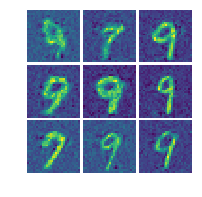

2018-05-18 22:05:18 iteration 21400/50000: current training loss = 13.995106 (=0.462933+0.048303+13.483870)


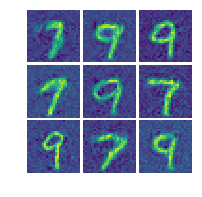

2018-05-18 22:05:58 iteration 21500/50000: current training loss = 12.154460 (=0.529602+0.066203+11.558655)


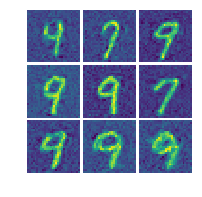

2018-05-18 22:06:37 iteration 21600/50000: current training loss = 17.513643 (=0.734288+0.057410+16.721945)


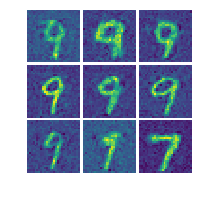

2018-05-18 22:07:17 iteration 21700/50000: current training loss = 16.246149 (=0.496856+0.049505+15.699788)


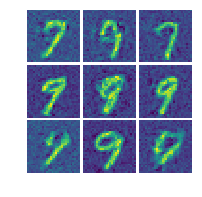

2018-05-18 22:07:56 iteration 21800/50000: current training loss = 11.918803 (=0.563053+0.067298+11.288452)


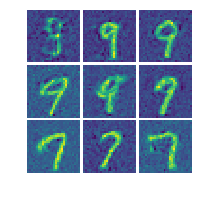

2018-05-18 22:08:34 iteration 21900/50000: current training loss = 13.290719 (=0.486719+0.060966+12.743035)


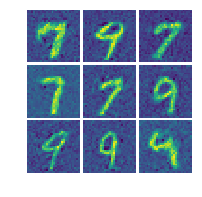

2018-05-18 22:09:14 iteration 22000/50000: current training loss = 13.093530 (=0.557565+0.059827+12.476137)


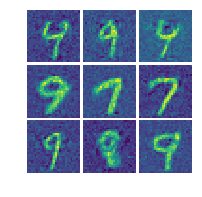

2018-05-18 22:09:53 iteration 22100/50000: current training loss = 19.398457 (=0.608874+0.054045+18.735537)


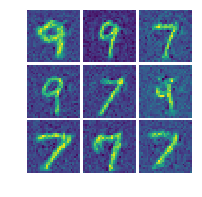

2018-05-18 22:10:32 iteration 22200/50000: current training loss = 14.398516 (=0.458993+0.059452+13.880071)


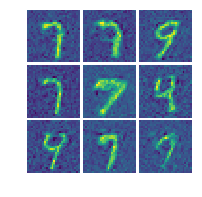

2018-05-18 22:11:12 iteration 22300/50000: current training loss = 10.537966 (=0.530083+0.081634+9.926249)


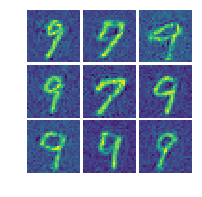

2018-05-18 22:11:51 iteration 22400/50000: current training loss = 14.938995 (=0.490374+0.063824+14.384798)


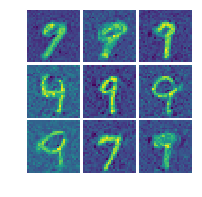

2018-05-18 22:12:31 iteration 22500/50000: current training loss = 11.919681 (=0.459516+0.064515+11.395650)


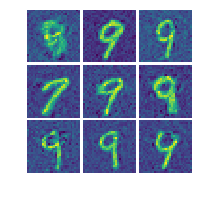

2018-05-18 22:13:10 iteration 22600/50000: current training loss = 15.971790 (=0.486956+0.047085+15.437749)


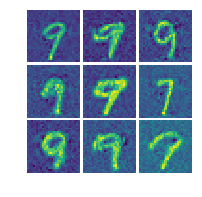

2018-05-18 22:13:49 iteration 22700/50000: current training loss = 14.283732 (=0.460553+0.065761+13.757419)


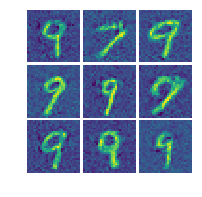

2018-05-18 22:14:29 iteration 22800/50000: current training loss = 12.146833 (=0.449747+0.066271+11.630816)


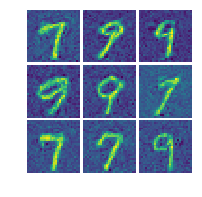

2018-05-18 22:15:08 iteration 22900/50000: current training loss = 14.860834 (=0.475266+0.055498+14.330070)


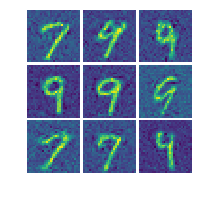

2018-05-18 22:15:48 iteration 23000/50000: current training loss = 12.288143 (=0.436652+0.054962+11.796529)


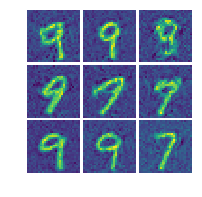

2018-05-18 22:16:28 iteration 23100/50000: current training loss = 12.301525 (=0.455930+0.065389+11.780206)


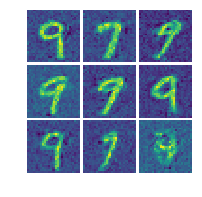

2018-05-18 22:17:08 iteration 23200/50000: current training loss = 12.097023 (=0.508207+0.061692+11.527123)


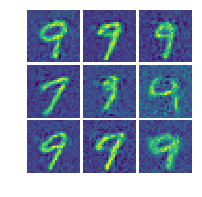

2018-05-18 22:17:48 iteration 23300/50000: current training loss = 12.046191 (=0.537917+0.060118+11.448156)


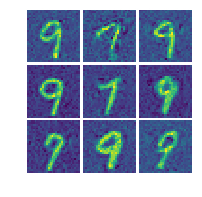

2018-05-18 22:18:25 iteration 23400/50000: current training loss = 12.882455 (=0.500323+0.060143+12.321988)


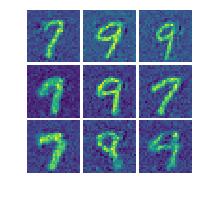

2018-05-18 22:19:04 iteration 23500/50000: current training loss = 12.731970 (=0.603700+0.057984+12.070285)


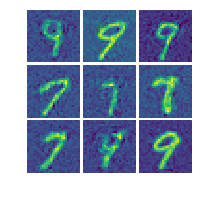

2018-05-18 22:19:43 iteration 23600/50000: current training loss = 11.235831 (=0.585799+0.075538+10.574494)


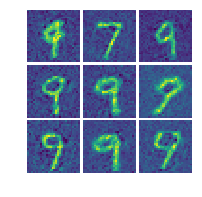

2018-05-18 22:20:23 iteration 23700/50000: current training loss = 13.142651 (=0.574752+0.063390+12.504509)


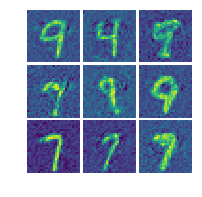

2018-05-18 22:21:01 iteration 23800/50000: current training loss = 10.788702 (=0.595800+0.079999+10.112903)


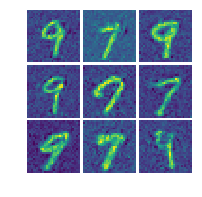

2018-05-18 22:21:41 iteration 23900/50000: current training loss = 16.744963 (=0.509509+0.039706+16.195747)


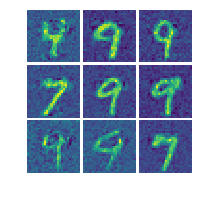

2018-05-18 22:22:19 iteration 24000/50000: current training loss = 12.213617 (=0.542178+0.064674+11.606766)


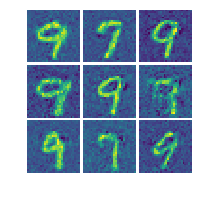

2018-05-18 22:22:58 iteration 24100/50000: current training loss = 13.874294 (=0.648393+0.059002+13.166899)


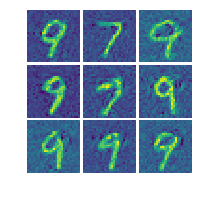

2018-05-18 22:23:36 iteration 24200/50000: current training loss = 11.022537 (=0.532417+0.070865+10.419255)


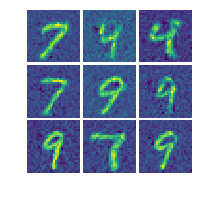

2018-05-18 22:24:16 iteration 24300/50000: current training loss = 13.731606 (=0.499586+0.055726+13.176293)


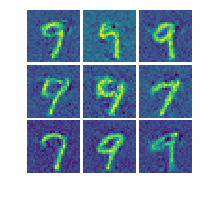

2018-05-18 22:24:55 iteration 24400/50000: current training loss = 15.039557 (=0.505949+0.058801+14.474807)


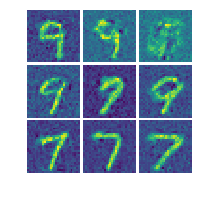

2018-05-18 22:25:33 iteration 24500/50000: current training loss = 11.133065 (=0.517295+0.069361+10.546409)


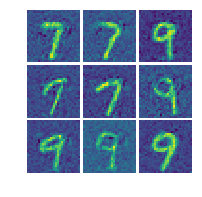

2018-05-18 22:26:12 iteration 24600/50000: current training loss = 14.927323 (=0.527325+0.053090+14.346909)


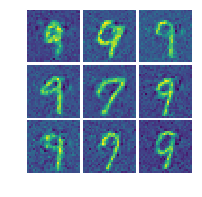

2018-05-18 22:26:51 iteration 24700/50000: current training loss = 12.170592 (=0.561167+0.064727+11.544698)


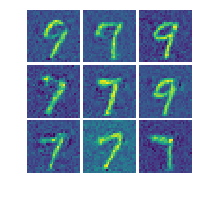

2018-05-18 22:27:27 iteration 24800/50000: current training loss = 12.190396 (=0.463786+0.058908+11.667702)


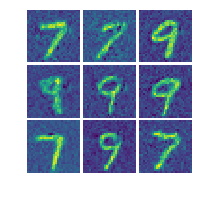

2018-05-18 22:28:06 iteration 24900/50000: current training loss = 11.675730 (=0.602974+0.071419+11.001337)


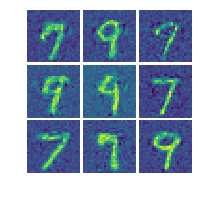

2018-05-18 22:28:45 iteration 25000/50000: current training loss = 17.354086 (=0.657977+0.041997+16.654112)


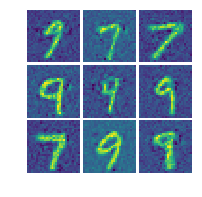

2018-05-18 22:29:25 iteration 25100/50000: current training loss = 16.941114 (=0.598117+0.054134+16.288862)


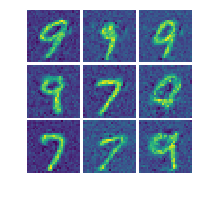

2018-05-18 22:30:03 iteration 25200/50000: current training loss = 13.599178 (=0.538186+0.057385+13.003607)


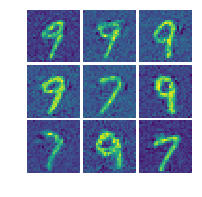

2018-05-18 22:30:42 iteration 25300/50000: current training loss = 17.458288 (=0.589369+0.054586+16.814333)


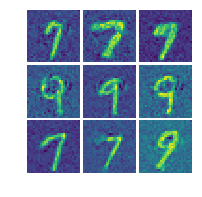

2018-05-18 22:31:22 iteration 25400/50000: current training loss = 13.067826 (=0.552684+0.056315+12.458827)


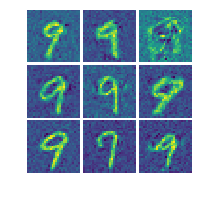

2018-05-18 22:32:01 iteration 25500/50000: current training loss = 16.954870 (=0.493607+0.043602+16.417662)


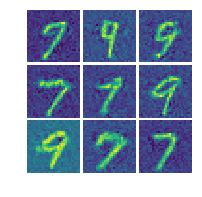

2018-05-18 22:32:39 iteration 25600/50000: current training loss = 14.560193 (=0.482170+0.051356+14.026667)


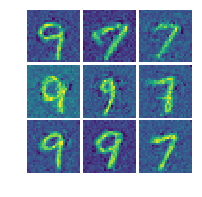

2018-05-18 22:33:18 iteration 25700/50000: current training loss = 13.287161 (=0.487134+0.065821+12.734207)


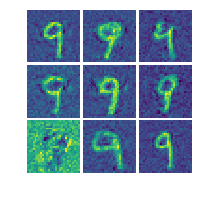

2018-05-18 22:33:58 iteration 25800/50000: current training loss = 15.001208 (=0.489808+0.048846+14.462555)


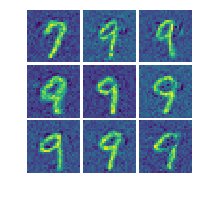

2018-05-18 22:34:37 iteration 25900/50000: current training loss = 17.259695 (=0.506617+0.046135+16.706944)


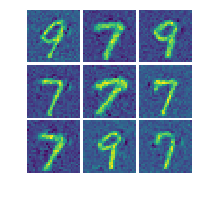

2018-05-18 22:35:17 iteration 26000/50000: current training loss = 17.427664 (=0.521495+0.057617+16.848553)


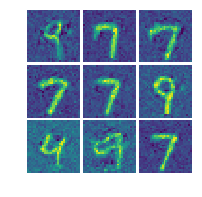

2018-05-18 22:35:56 iteration 26100/50000: current training loss = 15.742062 (=0.607087+0.049258+15.085715)


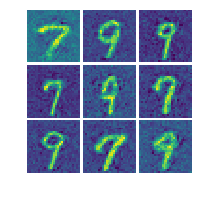

2018-05-18 22:36:36 iteration 26200/50000: current training loss = 14.168263 (=0.512822+0.059633+13.595808)


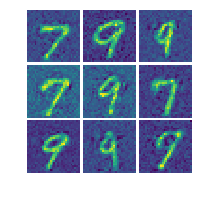

2018-05-18 22:37:16 iteration 26300/50000: current training loss = 15.994207 (=0.711139+0.048854+15.234214)


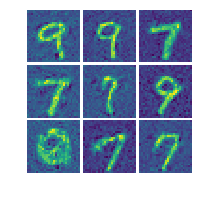

In [ ]:
batch_size=256
fake_size=128
noise_size=512
num_iteration=50000
print_every=100
test_every=100


classifier_train=3
vae_train=1

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for it in range(num_iteration):
        image,label=make_batch(batch_size,fake_size,noise_size)
#         image,label=make_batch_new(batch_size,fake_size)
        feed_dict={X:image,y:label}
        loss_num,l1,l2,l3=sess.run([tot_loss,tot_latent_loss,tot_classifier_loss,tot_likelihood_loss],feed_dict=feed_dict)
        for t in range(classifier_train):
#             _,__=sess.run([train_step1,extra_update_ops],feed_dict={X:image,y:label})
            _=sess.run([train_step1],feed_dict={X:image,y:label})
        for t in range(vae_train):
            _=sess.run([train_step2],feed_dict={X:image,y:label})
        
        if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f (=%f+%f+%f)' % (loss_num,l1,l2,l3))
        
        if it==0 or (it+1)%test_every==0 or it==num_iteration-1:
            display()
